# CopyCat: Example Usage on Robust04 Runs

This notebook assumes that you have a jupyter notebook with CopyCat installed.
To start a jupyter notebook with CopyCat installed and your local directory mounted, run:
```
docker run --rm -ti -v ${PWD}:/home/jovyan -p 8888:8888 webis/chatnoir-copycat:1.0-jupyter
```


Then, we use the CopyCat cli to deduplicate run files submitted to Robust04.

## Step 1: Download the Robust04 anserini index

The following code downloads the Robust04 index for Anserini that we use for the deduplication analysis on the robust04 corpus.

In [1]:
# Download the robust04 anserini index
import os.path
ROBUST_INDEX='index-robust04-20191213/'

if not os.path.isfile('robust04-index.tar.gz') or not os.path.isdir(ROBUST_INDEX):
     #cf.: https://github.com/castorini/pyserini/blob/7e03ecaef7514fa53e491786a073eabfff373a74/pyserini/prebuilt_index_info.py#L6
    !wget -O robust04-index.tar.gz 'https://git.uwaterloo.ca/jimmylin/anserini-indexes/raw/master/index-robust04-20191213.tar.gz'
    !tar -xvzf robust04-index.tar.gz
else:
    print('Robust04 index is already downloaded.')

Robust04 index is already downloaded.


# Step 2: Verify the Download; Double Check the Document Preprocessing

We have double-checked the preprocessing for the ClueWebs and CommonCrawls by many unit and integration tests.
Since the Robust04 dataset is not included in these tests, we have to double-check the preprocessing using some examples. (Please [see here](https://github.com/chatnoir-eu/copycat/blob/master/copycat-modules/document-preprocessing/README.md) for an overview of preprocessing options.)

To verify the preprocessing, we check a few documents manually.

In [2]:
# Use CopyCat to check the preprocessing for a single document

!copy-cat \
    --retrieveDocId FBIS4-56982 \
    --documents AnseriniIndex \
    --anseriniIndex $ROBUST_INDEX \
    --keepStopwords True \
    --output a --input a

bfn articl samuel blixen excerpt approxim month ago interior minist instal anti mafia unit try through intellig work break up connect between polic offic uruguayan crimin organ organ ar part intern mafia network dedic white slave trade drug traffick classifi inform handl interior ministri reveal mafia infiltr variou domest circl ha affect alarm number middl high rank polic offic ar numer indic organ dedic white slave trade drug traffick have develop support structur neighborhood level sport recreat organ mafia have enrol onli polic offic polic congress judici document indic mafia have also ensur complic sport entrepreneur profess sportsmen peopl entertain busi report even includ name deputi evid degr develop impun crimin organ intern connect ha alarm peopl highest level believ mafia ar try creat social support base like those brazil bolivia colombia countri drug traffick control entir neighborhood well entir line product activ nation mafia combin violenc coercion corrupt protect impun 

The preprocessed Robust04 document FBIS4-56982 looks good (stemming as expected, no problems with encoding, etc.).

## Step 3: Deduplicate all run files submitted to Robust04 Tracks

Now that we have double-checked that the document preprocessing works as expected for Robust04, we can deduplicate the run files and inspect the results.

In [ ]:
# this helper function executes copycat on the passed run file with the double-checked document preprocessing
def deduplicate_run_file(run_name, ranks):
    input_file = 'copycat-on-robust-data/trec13-robust-run-files/input.' + run_name + '.gz'
    output_file = 'copycat-on-robust-data/trec13-robust-run-files-deduplicated/run-' + run_name + '-deduplication-top' + str(ranks) + '.jsonl'
    
    !copy-cat \
        --output $output_file \
        --input  $input_file \
        --similarities "s3" \
        --s3Threshold 0.8 \
        --threads 10 \
        --ranks $ranks \
        --documents AnseriniIndex \
        --keepStopwords True \
        --anseriniIndex $ROBUST_INDEX

# Preprocess all runs
RUNS = !ls copycat-on-robust-data/trec13-robust-run-files/ |grep input|grep gz
for run in RUNS:
    for depth in [10]:
        deduplicate_run_file(run.replace('input.', '').replace('.gz', ''), depth)

The specified output 'copycat-on-robust-data/trec13-robust-run-files-deduplicated/run-apl04rsDw-deduplication-top10.jsonl' exists.
Skip...
Process topic 301
Process topic 302
Process topic 303
Process topic 304
Process topic 305
Process topic 306
Process topic 307
Process topic 308
Process topic 309
Process topic 310
Process topic 311
Process topic 312
Process topic 313
Process topic 314
Process topic 315
Process topic 316
Process topic 317
Process topic 318
Process topic 319
Process topic 320
Process topic 321
Process topic 322
Process topic 323
Process topic 324
Process topic 325
Process topic 326
Process topic 327
Process topic 328
Process topic 329
Process topic 330
Process topic 331
Process topic 332
Process topic 333
Process topic 334
Process topic 335
Process topic 336
Process topic 337
Process topic 338
Process topic 339
Process topic 340
Process topic 341
Process topic 342
Process topic 343
Process topic 344
Process topic 345
Process topic 346
Process topic 347
Process topic 3

Process topic 649
Process topic 650
Process topic 651
Process topic 652
Process topic 653
Process topic 654
Process topic 655
Process topic 656
Process topic 657
Process topic 658
Process topic 659
Process topic 660
Process topic 661
Process topic 662
Process topic 663
Process topic 664
Process topic 665
Process topic 666
Process topic 667
Process topic 668
Process topic 669
Process topic 670
Process topic 671
Process topic 672
Process topic 673
Process topic 674
Process topic 675
Process topic 676
Process topic 677
Process topic 678
Process topic 679
Process topic 680
Process topic 681
Process topic 682
Process topic 683
Process topic 684
Process topic 685
Process topic 686
Process topic 687
Process topic 688
Process topic 689
Process topic 690
Process topic 691
Process topic 692
Process topic 693
Process topic 694
Process topic 695
Process topic 696
Process topic 697
Process topic 698
Process topic 699
Process topic 700
Process topic 301
Process topic 302
Process topic 303
Process to

In [ ]:
RUNS = !ls copycat-on-robust-data/trec13-robust-run-files/ |grep input|grep gz
for run in RUNS:
    for depth in [100]:
        deduplicate_run_file(run.replace('input.', '').replace('.gz', ''), depth)

In [4]:
import json
import pandas as pd

def eval_with_threshold(threshold, run_file_name):
    rows = []
    with open(run_file_name) as jsonl_file:
        for jsonl in jsonl_file:
            dedup_data = json.loads(jsonl)
            docs_to_remove = []
            
            for sim in dedup_data['similarities']:
                if sim['similarities']['s3'] >=  threshold:
                    docs_to_remove += [sim['secondId']]

                
            rows += [{
                    'topic': dedup_data['topic'],
                    'duplicates': len(set(docs_to_remove)),
                    'docs': dedup_data['docs'],
                }]

    return rows

def eval_runs_with_threshold(threshold, run_files):
    rows = []
    for r in run_files:
        rows += eval_with_threshold(threshold, r)
    
    return pd.DataFrame(rows)

In [5]:
DEDUP_TARGET_DIR='copycat-on-robust-data/trec13-robust-run-files-deduplicated/'
ALL_DIRS=!ls $DEDUP_TARGET_DIR
ALL_DIRS = [DEDUP_TARGET_DIR + i for i in ALL_DIRS if '.jsonl' in i]

df = eval_runs_with_threshold(0.82, ALL_DIRS)
df['redundancy'] = df['duplicates']/df['docs']

In [6]:
df[['docs', 'redundancy']].groupby('docs').mean()

,redundancy
docs,
101,0.018693
1000,0.020308


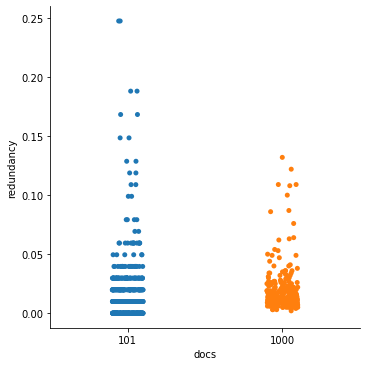

In [7]:
import seaborn as sns
sns.catplot(data=df, x='docs', y='redundancy', hue='docs')